In [1]:
import pyodbc
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

Importing plotly failed. Interactive plots will not work.


# Read data

In [3]:
cusor = cnxn.cursor()

In [4]:
sql = '''
    select * from General."Report Sources"."Return to Work"."Covid 19 Update"
'''

In [5]:
cusor.execute(sql)

In [6]:
response = cusor.fetchall()

In [7]:
data = pd.DataFrame.from_records(response, 
                                 columns=['state_fips', 'state_name', 
                                          'county_name', 'area_name', 'lat', 
                                          'long', 'date', 'cases', 'deaths',
                                         'county_fips','id2','population_estimate_2018'])

In [8]:
data.head()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018
0,05,Arkansas,Pulaski County,,34.7703106,-92.312996,2020-07-18,3578,69,5119,5119,392680
1,05,Arkansas,Pulaski County,,34.7703106,-92.312996,2020-07-19,3652,69,5119,5119,392680
2,05,Arkansas,Pulaski County,,34.7703106,-92.312996,2020-07-20,3717,69,5119,5119,392680
3,05,Arkansas,Pulaski County,,34.7703106,-92.312996,2020-07-21,3843,69,5119,5119,392680
4,05,Arkansas,Pulaski County,,34.7703106,-92.312996,2020-07-22,3923,69,5119,5119,392680


In [9]:
# Remove leading and trailing white spaces
data.replace('^\s+', '', regex=True, inplace=True)
data.replace('\s+$', '', regex=True, inplace=True)

In [10]:
data['cases'] = data['cases'].astype(int)
data['population_estimate_2018'] = data['population_estimate_2018'].astype(int)
data['date'] = pd.to_datetime(data['date'])

# County name is not unique - create State-County name

In [11]:
data['state_county'] = data['state_name'] + ', ' + data['county_name']

In [12]:
data['county_name'].unique()

array(['Pulaski County', 'Randolph County', 'St. Francis County', ...,
       'Patillas Municipio', 'Peñuelas Municipio', 'Ponce Municipio'],
      dtype=object)

In [13]:
data['state_county'].nunique(), data['county_name'].nunique()

(3180, 1933)

In [14]:
print(data['cases'].isna().sum(), data['date'].isna().sum())

0 0


In [15]:
data = data[data['state_name'] == 'Ohio'].copy()

In [16]:
data.tail()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018,state_county
256243,39,Ohio,Seneca County,,41.1199923,-83.1275469,2020-05-06,14,1,39147,39147,55207,"Ohio, Seneca County"
256244,39,Ohio,Seneca County,,41.1199923,-83.1275469,2020-05-07,14,1,39147,39147,55207,"Ohio, Seneca County"
256245,39,Ohio,Seneca County,,41.1199923,-83.1275469,2020-05-08,14,1,39147,39147,55207,"Ohio, Seneca County"
256246,39,Ohio,Seneca County,,41.1199923,-83.1275469,2020-05-09,14,1,39147,39147,55207,"Ohio, Seneca County"
256247,39,Ohio,Seneca County,,41.1199923,-83.1275469,2020-05-10,14,1,39147,39147,55207,"Ohio, Seneca County"


# Group by state_county and order by date

In [17]:
data = data.groupby('state_county').apply(pd.DataFrame.sort_values, 'date').reset_index(drop=True)

## Use recent 10 cases to calculate percentage change in cases

In [18]:
# lambda x: x[-10:].pct_change().mean()*100)
pct_change = data.groupby('state_county').apply(
    lambda x: x['cases'][-10:].pct_change().mean()*100).reset_index()
pct_change.columns = ['state_county', 'change_trend']

In [19]:
pct_change.head()

,state_county,change_trend
0,"Ohio, Adams County",3.837960
1,"Ohio, Allen County",2.530528
2,"Ohio, Ashland County",2.014739
3,"Ohio, Ashtabula County",1.105914
4,"Ohio, Athens County",2.713746


# Define growth

In [20]:
def growth(x):
    if x > 0.5 and x <=4:
        return "growth"
    elif x >4 and x<7:
        return "high growth"
    elif x>=7:
        return "very high growth"
    elif x>=-0.5 and x<=0.5:
        return "leveling off"
    else:
        return "cases decreasing"

In [21]:
pct_change['trend'] = pct_change['change_trend'].apply(growth)

In [22]:
pct_change.trend.value_counts()

growth              69
high growth         10
leveling off         6
very high growth     3
Name: trend, dtype: int64

In [23]:
prev = len(data)
data = data.merge(pct_change, how='left')
assert(prev == len(data))

In [24]:
data.tail()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018,state_county,change_trend,trend
10929,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-22,74,5,39175,39175,21935,"Ohio, Wyandot County",3.701466,growth
10930,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-23,84,5,39175,39175,21935,"Ohio, Wyandot County",3.701466,growth
10931,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-24,91,5,39175,39175,21935,"Ohio, Wyandot County",3.701466,growth
10932,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-25,92,5,39175,39175,21935,"Ohio, Wyandot County",3.701466,growth
10933,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-26,99,5,39175,39175,21935,"Ohio, Wyandot County",3.701466,growth


# Calculate current cases per hundred thousand population

In [25]:
# number of cases per hundred thousand population
data['cases_per_hud_thousand'] = data['cases']/data['population_estimate_2018'] *100000

In [26]:
data.head()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018,state_county,change_trend,trend,cases_per_hud_thousand
0,39,Ohio,Adams County,,38.8344683,-83.4780816,2020-04-04,1,0,39001,39001,27724,"Ohio, Adams County",3.83796,growth,3.606983
1,39,Ohio,Adams County,,38.8344683,-83.4780816,2020-04-05,2,0,39001,39001,27724,"Ohio, Adams County",3.83796,growth,7.213966
2,39,Ohio,Adams County,,38.8344683,-83.4780816,2020-04-06,2,0,39001,39001,27724,"Ohio, Adams County",3.83796,growth,7.213966
3,39,Ohio,Adams County,,38.8344683,-83.4780816,2020-04-07,2,0,39001,39001,27724,"Ohio, Adams County",3.83796,growth,7.213966
4,39,Ohio,Adams County,,38.8344683,-83.4780816,2020-04-08,2,0,39001,39001,27724,"Ohio, Adams County",3.83796,growth,7.213966


In [27]:
# taking the mean of last two cases to calculate current cases per hundred thousand population
cases_thou = data.groupby('state_county').apply(
    lambda x: x['cases_per_hud_thousand'][-2:].mean()).reset_index()

In [28]:
cases_thou.columns = ['state_county', 'current_cases_per_hund_thou']

In [29]:
quartiles = cases_thou['current_cases_per_hund_thou'].quantile([0.25, 0.75], interpolation='nearest')
q1 = list(quartiles)[0]
q2 = list(quartiles)[1]
med = cases_thou['current_cases_per_hund_thou'].median()

In [30]:
# defining high and low cases based on the quartiles
def cases_thousands(x):
    if x > q2:
        return 'very high cases'
    elif x>med and x<q2:
        return 'high cases'
    elif x<med and x>q1:
        return 'relatively low cases'
    else:
        return 'relatively very low cases'

In [31]:
cases_thou['current_number_cases_category'] = cases_thou['current_cases_per_hund_thou'].apply(cases_thousands)

In [32]:
cases_thou.head()

,state_county,current_cases_per_hund_thou,current_number_cases_category
0,"Ohio, Adams County",147.886308,relatively very low cases
1,"Ohio, Allen County",513.330022,high cases
2,"Ohio, Ashland County",213.043074,relatively very low cases
3,"Ohio, Ashtabula County",521.575908,high cases
4,"Ohio, Athens County",480.871494,high cases


In [33]:
cases_thou.current_number_cases_category.value_counts()

relatively very low cases    24
very high cases              22
high cases                   21
relatively low cases         21
Name: current_number_cases_category, dtype: int64

In [34]:
cases_thou[cases_thou.current_number_cases_category=='relatively very low cases'].head()

,state_county,current_cases_per_hund_thou,current_number_cases_category
0,"Ohio, Adams County",147.886308,relatively very low cases
2,"Ohio, Ashland County",213.043074,relatively very low cases
7,"Ohio, Brown County",189.211504,relatively very low cases
10,"Ohio, Champaign County",215.461630,relatively very low cases
21,"Ohio, Erie County",576.961737,relatively very low cases


In [35]:
prev = len(data)
data = data.merge(cases_thou, how='left')
assert(prev == len(data))

In [36]:
data.tail()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018,state_county,change_trend,trend,cases_per_hud_thousand,current_cases_per_hund_thou,current_number_cases_category
10929,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-22,74,5,39175,39175,21935,"Ohio, Wyandot County",3.701466,growth,337.360383,435.377251,high cases
10930,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-23,84,5,39175,39175,21935,"Ohio, Wyandot County",3.701466,growth,382.949624,435.377251,high cases
10931,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-24,91,5,39175,39175,21935,"Ohio, Wyandot County",3.701466,growth,414.862093,435.377251,high cases
10932,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-25,92,5,39175,39175,21935,"Ohio, Wyandot County",3.701466,growth,419.421017,435.377251,high cases
10933,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-07-26,99,5,39175,39175,21935,"Ohio, Wyandot County",3.701466,growth,451.333485,435.377251,high cases


# Shuffle counties

In [37]:
all_state_county = list(data['state_county'].unique())

In [38]:
# import random
# random.shuffle(all_state_county)

# Check time series with one county

In [39]:
ts = data[data['state_county']==all_state_county[0]].copy()

In [40]:
county_name =  all_state_county[9]
ts = data[data['state_county']==county_name].copy()
ts = ts[['date', 'cases']].copy()
ts.date = pd.to_datetime(ts.date)
#ts = ts.set_index(['date'])
ts.cases = ts.cases.astype(int)

In [41]:
all_state_county[9]

'Ohio, Carroll County'

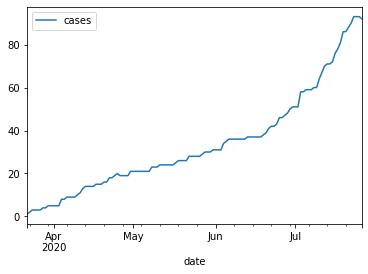

In [42]:
ts_check = ts.set_index('date')
ts_check.plot()

In [43]:
ts.tail()

,date,cases
1250,2020-07-22,90
1251,2020-07-23,93
1252,2020-07-24,93
1253,2020-07-25,93
1254,2020-07-26,92


# Prophet model

In [44]:
# Create prophet model for each county and use date only after '2020-06-01'
df = pd.DataFrame()
for ii in all_state_county:
    ts = data[data['state_county']==ii].copy()
    # EY second wave model
    ts = ts[ts.date >=pd.to_datetime('2020-06-01')].copy()
    # Date beyond which we start the forecast
    # end_date = ts['date'][-1:].values[0]
    # replicate last 10 rows
    replicated_last_10 = pd.concat([ts[-1:]]*10)
    int_df = pd.concat([ts, replicated_last_10])
    # check the baseline of last value moving forward
    ts = ts[['date', 'cases']].copy()
    ts.date = pd.to_datetime(ts.date)
    ts.columns = ['ds', 'y']
    model = Prophet()  # can also specify seasonality mode multplicative in the model
    model.fit(ts)
    future = model.make_future_dataframe(periods=10,freq = 'D')
    forecast = model.predict(future)
    fcast = forecast[['ds', 'yhat']].copy()
    fcast.columns = ['date','predicted_cases']
    int_df['date'] = list(fcast.date)
    int_df['predicted_cases'] = list(fcast.predicted_cases)
    # int_df['end_cases_date'] = end_date
    df = pd.concat([df,int_df])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [45]:
len(int_df)

66

In [46]:
int_df.head()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018,state_county,change_trend,trend,cases_per_hud_thousand,current_cases_per_hund_thou,current_number_cases_category,predicted_cases
10878,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-06-01,42,2,39175,39175,21935,"Ohio, Wyandot County",3.701466,growth,191.474812,435.377251,high cases,43.404031
10879,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-06-02,45,2,39175,39175,21935,"Ohio, Wyandot County",3.701466,growth,205.151584,435.377251,high cases,43.876295
10880,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-06-03,44,2,39175,39175,21935,"Ohio, Wyandot County",3.701466,growth,200.592660,435.377251,high cases,43.997964
10881,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-06-04,48,2,39175,39175,21935,"Ohio, Wyandot County",3.701466,growth,218.828357,435.377251,high cases,45.869630
10882,39,Ohio,Wyandot County,,40.8397816,-83.313681,2020-06-05,48,2,39175,39175,21935,"Ohio, Wyandot County",3.701466,growth,218.828357,435.377251,high cases,47.491073


# Individually check all cases

In [177]:
number_ = 20

In [178]:
check = df[df['state_county'] == all_state_county[number_]][['date', 'cases', 'predicted_cases']]

In [179]:
all_state_county[number_]

'Ohio, Delaware County'

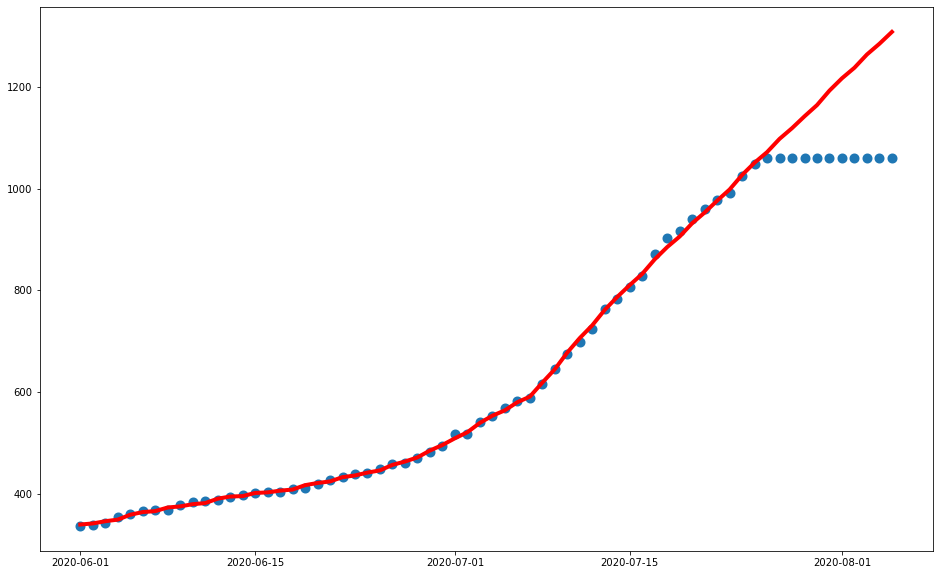

In [180]:
plt.figure (figsize=(16,10))
plt.scatter(check['date'], check['cases'], lw=4)
plt.plot(check['date'], check['predicted_cases'], color='r', lw=4)

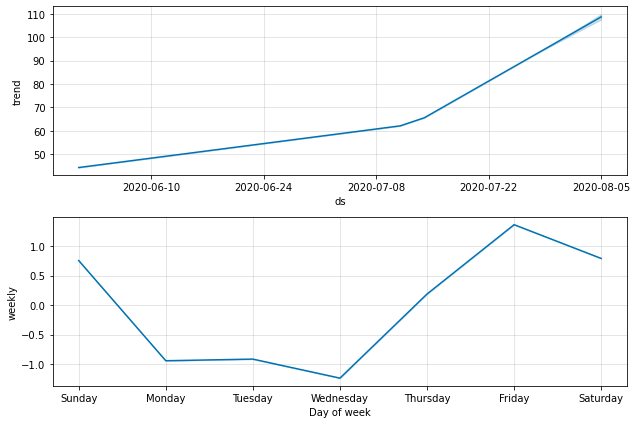

In [118]:
fig = model.plot_components(forecast)

In [54]:
df[df['state_county'] == all_state_county[number_]].head()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018,state_county,change_trend,trend,cases_per_hud_thousand,current_cases_per_hund_thou,current_number_cases_category,predicted_cases
310,39,Ohio,Ashland County,,40.843273,-82.2701271,2020-06-01,20,0,39005,39005,53745,"Ohio, Ashland County",2.014739,growth,37.212764,213.043074,relatively very low cases,17.368734
311,39,Ohio,Ashland County,,40.843273,-82.2701271,2020-06-02,20,0,39005,39005,53745,"Ohio, Ashland County",2.014739,growth,37.212764,213.043074,relatively very low cases,18.920635
312,39,Ohio,Ashland County,,40.843273,-82.2701271,2020-06-03,21,0,39005,39005,53745,"Ohio, Ashland County",2.014739,growth,39.073402,213.043074,relatively very low cases,20.347269
313,39,Ohio,Ashland County,,40.843273,-82.2701271,2020-06-04,21,0,39005,39005,53745,"Ohio, Ashland County",2.014739,growth,39.073402,213.043074,relatively very low cases,21.273823
314,39,Ohio,Ashland County,,40.843273,-82.2701271,2020-06-05,23,0,39005,39005,53745,"Ohio, Ashland County",2.014739,growth,42.794679,213.043074,relatively very low cases,22.104312


In [55]:
df.to_csv('predictions.csv')

In [56]:
df[df['state_county'] == all_state_county[number_]].tail()

,state_fips,state_name,county_name,area_name,lat,long,date,cases,deaths,county_fips,id2,population_estimate_2018,state_county,change_trend,trend,cases_per_hud_thousand,current_cases_per_hund_thou,current_number_cases_category,predicted_cases
365,39,Ohio,Ashland County,,40.843273,-82.2701271,2020-08-01,116,4,39005,39005,53745,"Ohio, Ashland County",2.014739,growth,215.834031,213.043074,relatively very low cases,137.296058
365,39,Ohio,Ashland County,,40.843273,-82.2701271,2020-08-02,116,4,39005,39005,53745,"Ohio, Ashland County",2.014739,growth,215.834031,213.043074,relatively very low cases,139.405120
365,39,Ohio,Ashland County,,40.843273,-82.2701271,2020-08-03,116,4,39005,39005,53745,"Ohio, Ashland County",2.014739,growth,215.834031,213.043074,relatively very low cases,142.509831
365,39,Ohio,Ashland County,,40.843273,-82.2701271,2020-08-04,116,4,39005,39005,53745,"Ohio, Ashland County",2.014739,growth,215.834031,213.043074,relatively very low cases,146.340885
365,39,Ohio,Ashland County,,40.843273,-82.2701271,2020-08-05,116,4,39005,39005,53745,"Ohio, Ashland County",2.014739,growth,215.834031,213.043074,relatively very low cases,150.046672
